In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seml
import pandas as pd
import json
from collections import defaultdict, Counter
from functools import reduce
import seaborn as sns
from scipy.stats import binned_statistic
from matplotlib.lines import Line2D
from tqdm import tqdm

In [2]:
%cd ..

/nfs/homedirs/fuchsgru/MastersThesis


In [3]:
import data.constants as dc
import model.constants as mc

In [4]:
collection_name = 'week24_edge_reconstruction_and_sn'
collection = seml.database.get_collection(collection_name)

In [5]:
by_status = defaultdict(set)
for r in collection.find():
    by_status[r['status']].add(r['config']['data']['dataset'])

In [6]:
by_status

defaultdict(set, {'COMPLETED': {'amazon_photo', 'citeseer', 'cora_full'}})

In [7]:
collection_name = 'week24_edge_reconstruction_and_sn'
collection = seml.database.get_collection(collection_name)
experiments = [{'config' : r['config'], 'result' : r['result'], 'id' : r['_id']} for r in collection.find() if r['status'] in ('COMPLETED',)]
for ex in experiments:
    # print(ex['result'].keys())
    ex['metrics'] = ex['result']['results']

In [8]:
# experiments_killed = [r for r in collection.find() if r['status'] in ('KILLED',)]

In [9]:
# experiments_failed = [r for r in collection.find() if r['status'] in ('FAILED',)]
# [ex['fail_trace'] for ex in experiments_failed]
# set(e['config']['data']['dataset'] for e in experiments_killed)

In [10]:
# Get the model w/o any biases from the spectral-norm experiment
collection_name_sn = 'week22_lipschitz_son'
collection_sn = seml.database.get_collection(collection_name_sn)


In [11]:
experiments_sn_all = [{'config' : r['config'], 'result' : r['result'], 'id' : r['_id']} for r in collection_sn.find() if r['status'] in ('COMPLETED',)]
for ex in experiments_sn_all:
    # print(ex['result'].keys())
    ex['metrics'] = ex['result']['results']

In [12]:
print(f'Found {len(experiments_sn_all)} experiments for spectral norm')

Found 6262 experiments for spectral norm


In [13]:
experiments_sn_all[0]['config']['model']

{'activation': 'leaky_relu',
 'hidden_sizes': [64],
 'leaky_relu_slope': 0.01,
 'model_type': 'gcn',
 'residual': False,
 'use_bias': True,
 'use_spectral_norm': False,
 'use_spectral_norm_on_last_layer': False,
 'weight_scale': 1.0}

In [14]:
# only consider experiments w/o output norm and w/ residual

experiments_sn = [ex for ex in experiments_sn_all if 
                  ( # Experiments with spectral norm and no reco
                      ex['config']['model']['use_spectral_norm'] and 
                       not ex['config']['model']['use_spectral_norm_on_last_layer'] and
                       ex['config']['model']['residual']
                  )
                  or
                  ( # Experiments with no spectral norm and no reco, i.e. no further ind. biases
                      not ex['config']['model']['use_spectral_norm'] and 
                      not ex['config']['model']['residual']
                  )
                 ]
print(f'Kept {len(experiments_sn)} experiments of spectral norm without ind. biases')




Kept 1618 experiments of spectral norm without ind. biases


In [15]:
# Get the reconstruction biases w/o spectral norm
collection_name_reco = 'week24_edge_reconstruction'
collection_reco = seml.database.get_collection(collection_name_reco)

experiments_reco_all = [{'config' : r['config'], 'result' : r['result'], 'id' : r['_id']} for r in collection_reco.find() if r['status'] in ('COMPLETED',)]
for ex in experiments_reco_all:
    # print(ex['result'].keys())
    ex['metrics'] = ex['result']['results']


In [16]:
print(f'Found {len(experiments_reco_all)} experiments for edge reconstruction')

Found 879 experiments for edge reconstruction


In [17]:
# only consider experiments w/ loss weight 1.0

experiments_reco = [ex for ex in experiments_reco_all if 
                  ex['config']['model']['reconstruction']['loss_weight'] == 1.0
                 ]
print(f'Kept {len(experiments_reco)} experiments of spectral norm without ind. biases')




Kept 138 experiments of spectral norm without ind. biases


In [18]:
keys = set()
for ex in experiments:
    keys |= set(ex['metrics'].keys())

list(keys)

['ood_auroc_gpc-eye-mode:weighted-relative:False:no_loc_fit-95conf-no-edges_test',
 'ood_auroc_gpc-diag-mode:max-relative:False:no_ber_fit-95conf-no-edges_val',
 'ood_auroc_gpc-full-mode:max-relative:True:no_normal_fit-95conf-no-edges_test',
 'misclassification_aucpr_gpc-diag-mode:weighted-relative:False:no_loc_fit-mask_test',
 'ood_aucpr_gpc-eye-mode:weighted-relative:False:no_ber_fit-mask_test',
 'misclassification_auroc_gpc-iso-mode:max-relative:True:no_normal_fit-mask-no-edges_val',
 'ood_aucpr_gpc-eye-mode:max-relative:True:no_normal_fit-mask_val',
 'misclassification_auroc_gpc-iso-mode:weighted-relative:False:no_loc_fit-mask-no-edges_val',
 'ood_aucpr_gpc-full-mode:max-relative:True:no_loc_fit-mask-no-edges_test',
 'misclassification_auroc_gpc-full-mode:weighted-relative:True:no_normal_fit-95conf_val',
 'ood_aucpr_gpc-diag-mode:max-relative:True:no_normal_fit-mask_test',
 'ood_aucpr_gpc-full-mode:max-relative:True:no_ber_fit-mask_test',
 'misclassification_auroc_gpc-iso-mode:weig

In [19]:
METRIC = 'Metric'
AUROC = 'AUC-ROC'
AUCPR = 'AUC-PR'

SETTING = 'Setting'
HYBRID = 'Inductive'
TRANSDUCTIVE = 'Transductive'
LOC = 'Leave Out Classes'
NORMAL = 'Normal'
BERNOULLI = 'Bernoulli'
NO_EDGES = 'No Edges'
PROXY = 'Proxy'
EXPERIMENT = 'Experiment'
DATASET = 'Dataset'
PERTURBATION = 'Perturbations'

RESIDUAL = 'Residual'
SPECTRAL_NORM = 'Spectral Norm'
SPECTRAL_OUTPUT_NORM = 'Spectral Norm on Last Layer'
WEIGHT_SCALE = 'Weight Scale'
LOWER_LIPSCHITZ = 'Empirical Lower\nLipschitz Bound'
UPPER_LIPSCHITZ = 'Empirical Upper\nLipschitz Bound'

OOD_TYPE = 'O.O.D. Type'

EPISTEMIC = 'Epistemic'
ALEATORIC = 'Aleatoric'

RECONSTRUCTION_TYPE = 'Edge Reconstruction'
RECONSTRUCTION_WEIGHT = 'Reconstruction Loss Weight'
AUTOENCODER = 'BCE'
ENERGY = 'Energy'
TRIPLET = 'Triplet'

ACCURACY = 'Accuracy'
# ECE = 'Expected Calibration Error'
ECE = 'ECE'

In [20]:
mode = 'test'

In [21]:
ex['config']['model']

{'activation': 'leaky_relu',
 'hidden_sizes': [64],
 'leaky_relu_slope': 0.01,
 'model_type': 'gcn',
 'reconstruction': {'loss_weight': 1.0, 'reconstruction_type': 'energy'},
 'residual': True,
 'use_bias': True,
 'use_spectral_norm': True,
 'weight_scale': 200.0}

In [22]:
[k for k in ex['metrics'].keys() if 'no-edges' in k and 'auroc' in k]

['ood_auroc_total-predictive-entropy_ber-no-edges_val',
 'misclassification_auroc_total-predictive-entropy_ber-no-edges_val',
 'ood_auroc_max-score_ber-no-edges_val',
 'misclassification_auroc_max-score_ber-no-edges_val',
 'ood_auroc_logit-energy_ber-no-edges_val',
 'misclassification_auroc_logit-energy_ber-no-edges_val',
 'ood_auroc_gpc-full-mode:weighted-relative:False:no_ber_fit-mask-no-edges_val',
 'misclassification_auroc_gpc-full-mode:weighted-relative:False:no_ber_fit-mask-no-edges_val',
 'ood_auroc_gpc-full-mode:weighted-relative:True:no_ber_fit-mask-no-edges_val',
 'misclassification_auroc_gpc-full-mode:weighted-relative:True:no_ber_fit-mask-no-edges_val',
 'ood_auroc_gpc-full-mode:max-relative:False:no_ber_fit-mask-no-edges_val',
 'misclassification_auroc_gpc-full-mode:max-relative:False:no_ber_fit-mask-no-edges_val',
 'ood_auroc_gpc-full-mode:max-relative:True:no_ber_fit-mask-no-edges_val',
 'misclassification_auroc_gpc-full-mode:max-relative:True:no_ber_fit-mask-no-edges_va

In [23]:
# epistemic_proxy = 'ood_gpc-diag-mode:weighted-relative:False:no_fit-95conf'
aleatoric_proxy = 'ood_max-score'
epistemic_proxy = 'ood_gpc-diag-mode:weighted-relative:False:no_fit-mask'
# metric = 'auroc'
# METRIC = 'AUC-ROC'
metric = 'auroc'
METRIC = 'AUC-ROC'

In [24]:
data_proxy, data_acc_ece = [], []

unrecognized = set()

for ex in tqdm(experiments + experiments_sn + experiments_reco):
    cfg = ex['config']
    base = {
        SETTING : {dc.HYBRID : HYBRID, dc.TRANSDUCTIVE : TRANSDUCTIVE}[cfg['data']['setting']],
        OOD_TYPE : {dc.LEFT_OUT_CLASSES : LOC, dc.PERTURBATION : PERTURBATION}[cfg['data']['ood_type']],
        DATASET :  cfg['data']['dataset'],
        LOWER_LIPSCHITZ : ex['metrics'][f'empirical_lipschitz_{mode}_slope_min_perturbation_noise_{mode}'][0]['value'],
        UPPER_LIPSCHITZ : ex['metrics'][f'empirical_lipschitz_{mode}_slope_max_perturbation_noise_{mode}'][0]['value'],
    }
    if 'reconstruction' in cfg['model']:
        base[RECONSTRUCTION_TYPE] = {
            mc.AUTOENCODER : AUTOENCODER, mc.TRIPLET : TRIPLET, mc.ENERGY : ENERGY,
        }[cfg['model']['reconstruction']['reconstruction_type']]
        base[RECONSTRUCTION_WEIGHT] = cfg['model']['reconstruction']['loss_weight']
    if 'residual' in cfg['model']:
        base[RESIDUAL] = cfg['model']['residual']
    if 'use_spectral_norm' in cfg['model']:
        base[SPECTRAL_NORM] = cfg['model']['use_spectral_norm']
        base[WEIGHT_SCALE] = cfg['model']['weight_scale']
    
    
    data_acc_ece.append(base | {
        ACCURACY : ex['metrics'][f'accuracy_{mode}_{mode}'][0],
        ECE : ex['metrics'][f'ece_{mode}_{mode}'][0]['value'],
    })
    for k, vs in ex['metrics'].items():
        if metric in k and k.endswith('_' + mode):
            k = k.replace(metric + '_', '').replace('_' + mode, '')
            if '-no-edges' in k:
                no_edges = True
                k = k.replace('-no-edges', '')
            else:
                no_edges = False
                
            if '_loc' in k or '-loc' in k:
                exp = LOC
                k = k.replace('_loc', '').replace('-loc', '')
            elif '_ber' in k or '-ber' in k:
                exp = BERNOULLI
                k = k.replace('_ber', '').replace('-ber', '')
            elif '_normal' in k or '-normal' in k:
                exp = NORMAL
                k = k.replace('_normal', '').replace('-normal', '')
            else:
                raise ValueError(k)
            
            metric_cfg = {}
            
            if k == aleatoric_proxy:
                metric_cfg[PROXY] = ALEATORIC
            elif k == epistemic_proxy:
                metric_cfg[PROXY] = EPISTEMIC
            else:
                unrecognized.add(k)
                continue
            
            for v in vs:
                v = v['value']
                data_proxy.append({
                    METRIC : v,
                    NO_EDGES : no_edges,
                    EXPERIMENT : exp,
                } | metric_cfg | base | {
                    ACCURACY : ex['metrics'][f'accuracy_{mode}_{mode}'][0],
                    ECE : ex['metrics'][f'ece_{mode}_{mode}'][0]['value'],
                }
                )
                

100%|██████████| 3376/3376 [00:03<00:00, 864.10it/s] 


In [25]:
df_proxy = pd.DataFrame(data_proxy)
df_acc_ece = pd.DataFrame(data_acc_ece)

In [26]:
df_proxy[
    (df_proxy[EXPERIMENT] == LOC) &
    (df_proxy[NO_EDGES] == False) &
    (df_proxy[SETTING] == HYBRID) &
    (df_proxy[PROXY] == EPISTEMIC)
]

,AUC-ROC,No Edges,Experiment,Proxy,Setting,O.O.D. Type,Dataset,Empirical Lower\nLipschitz Bound,Empirical Upper\nLipschitz Bound,Edge Reconstruction,Reconstruction Loss Weight,Residual,Spectral Norm,Weight Scale,Accuracy,ECE
543,0.692810,False,Leave Out Classes,Epistemic,Inductive,Leave Out Classes,cora_full,0.015028,0.402435,BCE,1.0,True,True,1.0,0.755789,0.593735
547,0.564240,False,Leave Out Classes,Epistemic,Inductive,Leave Out Classes,cora_full,0.007435,0.364756,BCE,1.0,True,True,1.0,0.797071,0.524755
551,0.688776,False,Leave Out Classes,Epistemic,Inductive,Leave Out Classes,cora_full,0.017973,0.374236,BCE,1.0,True,True,1.0,0.677019,0.514013
555,0.779555,False,Leave Out Classes,Epistemic,Inductive,Leave Out Classes,cora_full,0.014542,0.380022,BCE,1.0,True,True,1.0,0.797895,0.632447
559,0.784539,False,Leave Out Classes,Epistemic,Inductive,Leave Out Classes,cora_full,0.197009,2.097149,BCE,1.0,True,True,1.0,0.744770,0.582838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19635,0.812140,False,Leave Out Classes,Epistemic,Inductive,Leave Out Classes,cora_full,0.007014,1.057103,Energy,1.0,NaN,NaN,NaN,0.822176,0.224413
19639,0.886189,False,Leave Out Classes,Epistemic,Inductive,Leave Out Classes,cora_full,0.007275,0.911066,Energy,1.0,NaN,NaN,NaN,0.811594,0.190294
20183,0.809191,False,Leave Out Classes,Epistemic,Inductive,Leave Out Classes,citeseer,0.011439,1.290174,BCE,1.0,NaN,NaN,NaN,0.768362,0.108134
20187,0.716413,False,Leave Out Classes,Epistemic,Inductive,Leave Out Classes,citeseer,0.009438,1.098297,BCE,1.0,NaN,NaN,NaN,0.822222,0.185703


In [27]:
set(df_proxy[RESIDUAL]), set(df_proxy[OOD_TYPE]), set(df_proxy[RECONSTRUCTION_TYPE]), set(df_proxy[RESIDUAL])

({False, True, nan},
 {'Leave Out Classes', 'Perturbations'},
 {'BCE', 'Energy', 'Triplet', nan},
 {False, True, nan})

In [28]:
df_proxy[df_proxy[RESIDUAL] == False]

,AUC-ROC,No Edges,Experiment,Proxy,Setting,O.O.D. Type,Dataset,Empirical Lower\nLipschitz Bound,Empirical Upper\nLipschitz Bound,Edge Reconstruction,Reconstruction Loss Weight,Residual,Spectral Norm,Weight Scale,Accuracy,ECE
9720,0.862215,True,Leave Out Classes,Aleatoric,Transductive,Leave Out Classes,cora_full,0.008169,0.844376,NaN,NaN,False,False,1.0,0.853516,0.173769
9721,0.540945,True,Leave Out Classes,Epistemic,Transductive,Leave Out Classes,cora_full,0.008169,0.844376,NaN,NaN,False,False,1.0,0.853516,0.173769
9722,0.989750,False,Leave Out Classes,Aleatoric,Transductive,Leave Out Classes,cora_full,0.008169,0.844376,NaN,NaN,False,False,1.0,0.853516,0.173769
9723,0.877223,False,Leave Out Classes,Epistemic,Transductive,Leave Out Classes,cora_full,0.008169,0.844376,NaN,NaN,False,False,1.0,0.853516,0.173769
9724,0.852589,True,Leave Out Classes,Aleatoric,Transductive,Leave Out Classes,cora_full,0.005772,0.807975,NaN,NaN,False,False,1.0,0.832016,0.169277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17419,0.549737,False,Bernoulli,Epistemic,Inductive,Perturbations,citeseer,0.021232,1.342457,NaN,NaN,False,False,1.0,0.721014,0.093765
17420,0.030368,True,Normal,Aleatoric,Inductive,Perturbations,citeseer,0.021232,1.342457,NaN,NaN,False,False,1.0,0.721014,0.093765
17421,1.000000,True,Normal,Epistemic,Inductive,Perturbations,citeseer,0.021232,1.342457,NaN,NaN,False,False,1.0,0.721014,0.093765
17422,0.308465,False,Normal,Aleatoric,Inductive,Perturbations,citeseer,0.021232,1.342457,NaN,NaN,False,False,1.0,0.721014,0.093765


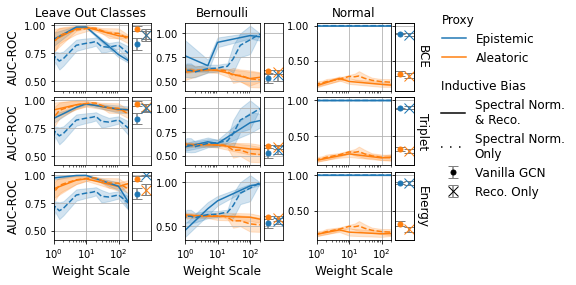

In [31]:
def grouped_values_with_error(x, y):
    """ Groups a set of x, y values according to x and calculates mean and std """
    x_ret, y_mean, y_err = [], [], []
    for xi in sorted(np.unique(x)):
        y_mean.append(y[x == xi].mean())
        y_err.append(y[x == xi].std())
        x_ret.append(xi)
    return np.array(x_ret), np.array(y_mean), np.array(y_err)
        

def facet_plot_experiment_reco_type_proxy_hue(df, x_name, y_name):

    fig, axs = plt.subplots(3, 9, figsize=(7, 4), gridspec_kw = {
            'width_ratios' : [0.8, 0.2, 0.28] * 3, 'wspace' : 0.1, 'hspace' : 0.1,
    }, sharey=False, sharex=False)
    
    baseline_axs = axs[:, 1::3]
    proxy_axs = axs[:, 0::3]
    invisible_axs = axs[:, 2::3]

    ls_base = (0, (1, 5)) # The linestyle for the baseline

    for col_idx, experiment in enumerate((LOC, BERNOULLI, NORMAL)):
        df_exp = df[
                (df[EXPERIMENT] == experiment)
            ]
        
        # First baseline: Vanilla GCN
        df_vgcn = df_exp[(df_exp[SPECTRAL_NORM] == False) & ~np.isfinite(df_exp[RECONSTRUCTION_WEIGHT])]
        y_alea_vgcn = df_vgcn[df_vgcn[PROXY] == ALEATORIC][y_name]
        y_epi_vgcn = df_vgcn[df_vgcn[PROXY] == EPISTEMIC][y_name]
        # print(f'Shape for VGCN ys', y_alea_vgcn.shape, y_epi_vgcn.shape)
        
        # Second baseline: GCN + Spectral Norm (of different weight scale)
        df_gcn_sn = df_exp[(df_exp[SPECTRAL_NORM] == True) & ~np.isfinite(df_exp[RECONSTRUCTION_WEIGHT])]
        y_alea_gcn_sn = df_gcn_sn[df_gcn_sn[PROXY] == ALEATORIC][y_name]
        x_alea_gcn_sn = df_gcn_sn[df_gcn_sn[PROXY] == ALEATORIC][x_name]
        y_epi_gcn_sn = df_gcn_sn[df_gcn_sn[PROXY] == EPISTEMIC][y_name]
        x_epi_gcn_sn = df_gcn_sn[df_gcn_sn[PROXY] == EPISTEMIC][x_name]
        # print(f'Item counts for GCN + SN ys (both epi + alea)', set(df_gcn_sn.groupby(WEIGHT_SCALE).count().to_numpy().flatten()))
        
        for row_idx, reco_type in enumerate((AUTOENCODER, TRIPLET, ENERGY)):
            ax = proxy_axs[row_idx, col_idx]
            df_reco_type = df_exp[df_exp[RECONSTRUCTION_TYPE] == reco_type]
            df_reco_no_sn = df_reco_type[(df_reco_type[SPECTRAL_NORM] != True)]
            df_reco_sn = df_reco_type[(df_reco_type[SPECTRAL_NORM] == True)]
            
            # Plot epi and alea for the reco type and spectral norm
            x_alea, y_mean_alea, y_err_alea = grouped_values_with_error(
                df_reco_sn[df_reco_sn[PROXY] == ALEATORIC][x_name], df_reco_sn[df_reco_sn[PROXY] == ALEATORIC][y_name])
            x_epi, y_mean_epi, y_err_epi = grouped_values_with_error(
                df_reco_sn[df_reco_sn[PROXY] == EPISTEMIC][x_name], df_reco_sn[df_reco_sn[PROXY] == EPISTEMIC][y_name])
            
            ax.plot(x_alea, y_mean_alea, color='tab:orange', ls='-')
            ax.fill_between(x_alea, y_mean_alea - y_err_alea, y_mean_alea + y_err_alea, alpha=.2, color='tab:orange')
            
            ax.plot(x_epi, y_mean_epi, color='tab:blue', ls='-')
            ax.fill_between(x_epi, y_mean_epi - y_err_epi, y_mean_epi + y_err_epi, alpha=.2, color='tab:blue')
            
            
            
            # 2nd baseline, reconstruction w/o spectral norm
            x_alea_sn, y_mean_alea_sn, y_err_alea_sn = grouped_values_with_error(
                x_alea_gcn_sn, y_alea_gcn_sn,
            )
            x_epi_sn, y_mean_epi_sn, y_err_epi_sn = grouped_values_with_error(
                x_epi_gcn_sn, y_epi_gcn_sn,
            )
            ax.plot(x_alea_sn, y_mean_alea_sn, color='tab:orange', ls='--')
            ax.fill_between(x_alea_sn, y_mean_alea_sn - y_err_alea_sn, y_mean_alea_sn + y_err_alea_sn, alpha=.2, color='tab:orange')
            ax.plot(x_epi_sn, y_mean_epi_sn, color='tab:blue', ls='--')
            ax.fill_between(x_epi_sn, y_mean_epi_sn - y_err_epi_sn, y_mean_epi_sn + y_err_epi_sn, alpha=.2, color='tab:blue')
            
            # Plot first baseline: VGCN
            baseline_axs[row_idx, col_idx].errorbar(
                [0], [y_alea_vgcn.mean()], yerr=[y_alea_vgcn.std()], ecolor='gray', capsize=5, 
                fmt='.', color='tab:orange', ms=10)
            baseline_axs[row_idx, col_idx].errorbar(
                [0], [y_epi_vgcn.mean()], yerr=[y_epi_vgcn.std()], ecolor='gray', capsize=5, 
                fmt='.', color='tab:blue', ms=10)
            
            # 3rd baseline: Reco only
            y_alea_no_sn = df_reco_no_sn[df_reco_no_sn[PROXY] == ALEATORIC][y_name]
            y_epi_no_sn = df_reco_no_sn[df_reco_no_sn[PROXY] == EPISTEMIC][y_name]
            baseline_axs[row_idx, col_idx].errorbar(
                [1], [y_alea_no_sn.mean()], yerr=[y_alea_no_sn.std()], ecolor='gray', capsize=5, 
                fmt='x', color='tab:orange', ms=10)
            baseline_axs[row_idx, col_idx].errorbar(
                [1], [y_epi_no_sn.mean()], yerr=[y_epi_no_sn.std()], ecolor='gray', capsize=5, 
                fmt='x', color='tab:blue', ms=10)
            
            x_lim = (df_reco_type[x_name].min(), df_reco_type[x_name].max())
            ax.set_xlim(x_lim)
            ax.set_xscale('log')
            
            from matplotlib.ticker import FormatStrFormatter
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            
            # Synchronize y-limits
            y_min, y_max = ax.get_ylim()
            y_min_bl, y_max_bl = baseline_axs[row_idx, col_idx].get_ylim()
            ax.set_ylim(min(y_min, y_min_bl), max(y_max, y_max_bl))
            baseline_axs[row_idx, col_idx].set_ylim(min(y_min, y_min_bl), max(y_max, y_max_bl))
            

        proxy_axs[0, col_idx].set_title(experiment, fontsize=12)
        proxy_axs[-1, col_idx].set_xlabel(x_name, fontsize=12)

    
    # Configure axis
    for ax in axs[:, 1::3].flatten():
        ax.tick_params(axis='y', labelleft=False, left=False)
    for ax in invisible_axs.flatten():
        ax.set_visible(False)
    for ax in axs[:-1, :].flatten():
        ax.tick_params(axis='x', bottom=False, labelbottom=False)
    for ax in baseline_axs.flatten():
        ax.tick_params(axis='x', bottom=False, labelbottom=False)
        ax.set_xlim(-0.5, 1.5)
    for ax in proxy_axs.flatten():
        ax.grid(which='major')
    for ax in baseline_axs[:, :].flatten():
        ax.grid(which='major', axis='y')
    for ax in proxy_axs[:, 0].flatten():
        ax.set_ylabel(y_name, fontsize=12)
    #for ax in axs.flatten():
        #ax.set_ylim(-0.1, 1.1)
        
    for row_idx, reco_type in enumerate((AUTOENCODER, TRIPLET, ENERGY)): 
            ax2 = baseline_axs[row_idx, -1].twinx()
            ax2.set_ylabel(reco_type, fontsize=12, rotation=270, labelpad=15)
            ax2.set_yticks([])
        
    handles = []
    handles += axs[-1, -1].plot([], [], color='tab:blue', label=EPISTEMIC, linestyle='-')
    handles += axs[-1, -1].plot([], [], color='tab:orange', label=ALEATORIC, linestyle='-')
    legend_proxy = fig.legend(handles, [EPISTEMIC, ALEATORIC,], 
                              title='Proxy', loc='upper right', bbox_to_anchor=(1.12-0.02, 0.95), frameon=False, fontsize=12)
    plt.setp(legend_proxy.get_title(),fontsize=12)
    legend_proxy._legend_box.align = "left"
    
    handles = []
    handles += axs[-1, -1].plot([], [], color='black', label='No Reconstruction', linestyle='-')
    handles += axs[-1, -1].plot([], [], color='black', label='No Reconstruction', linestyle=ls_base)
    handles += [axs[-1, -1].errorbar([0], [0], yerr=[2], ecolor='gray', capsize=5, 
                fmt='.', color='black', ms=10)]
    handles += [axs[-1, -1].errorbar([0], [0], yerr=[2], ecolor='gray', capsize=5, 
                fmt='x', color='black', ms=10)]
    legend_proxy = fig.legend(handles, ['Spectral Norm.\n& Reco.', 'Spectral Norm.\nOnly', 'Vanilla GCN', 'Reco. Only'], 
                              title='Inductive Bias', loc='upper right', bbox_to_anchor=(1.18 -0.02, 0.72), frameon=False, fontsize=12)
    plt.setp(legend_proxy.get_title(),fontsize=12)
    legend_proxy._legend_box.align = "left"
    
    axs[-1, -1].add_artist(legend_proxy)
    
    return fig, axs


fig, axs = facet_plot_experiment_reco_type_proxy_hue(df_proxy[
    (df_proxy[NO_EDGES] == False) &
    (df_proxy[DATASET] == dc.CORA_FULL) &
    (df_proxy[SETTING] == TRANSDUCTIVE)
], WEIGHT_SCALE, METRIC)
for ax in axs.flatten():
    pass
    # ax.set_ylim(-.1, 1.1)

thesis_nbs/edge_reconstruction_and_spectral_norm_plots/cora_full-inductive-Weight-Scale-AUC-ROC-no-edges.pdf
thesis_nbs/edge_reconstruction_and_spectral_norm_plots/citeseer-inductive-Weight-Scale-AUC-ROC-no-edges.pdf
thesis_nbs/edge_reconstruction_and_spectral_norm_plots/amazon_photo-inductive-Weight-Scale-AUC-ROC-no-edges.pdf
thesis_nbs/edge_reconstruction_and_spectral_norm_plots/cora_full-transductive-Weight-Scale-AUC-ROC-no-edges.pdf
thesis_nbs/edge_reconstruction_and_spectral_norm_plots/citeseer-transductive-Weight-Scale-AUC-ROC-no-edges.pdf
thesis_nbs/edge_reconstruction_and_spectral_norm_plots/amazon_photo-transductive-Weight-Scale-AUC-ROC-no-edges.pdf
thesis_nbs/edge_reconstruction_and_spectral_norm_plots/cora_full-inductive-Weight-Scale-AUC-ROC.pdf
thesis_nbs/edge_reconstruction_and_spectral_norm_plots/citeseer-inductive-Weight-Scale-AUC-ROC.pdf
thesis_nbs/edge_reconstruction_and_spectral_norm_plots/amazon_photo-inductive-Weight-Scale-AUC-ROC.pdf
thesis_nbs/edge_reconstruction_

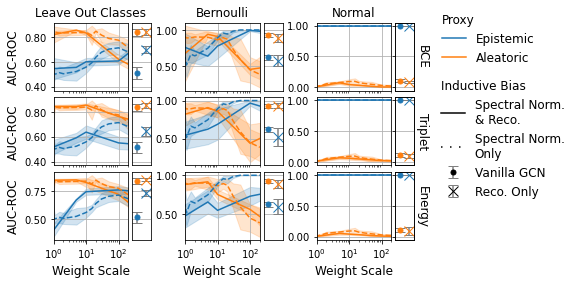

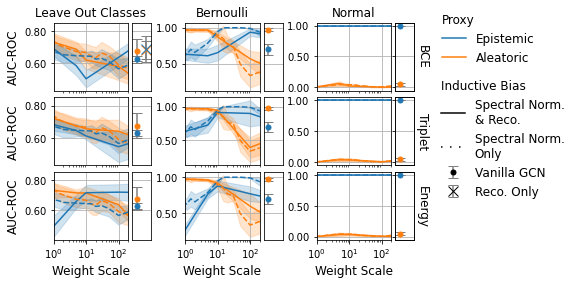

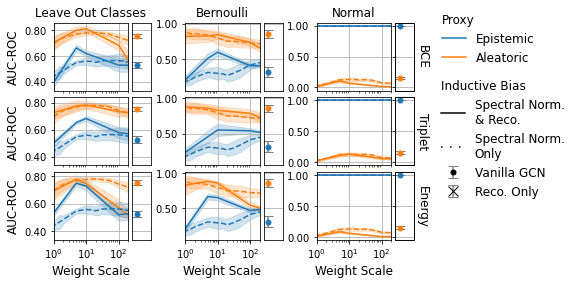

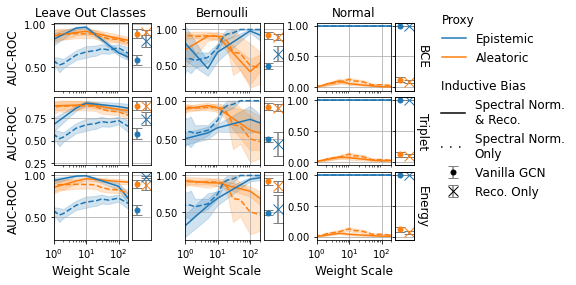

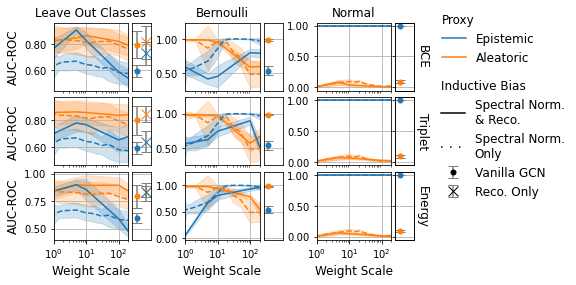

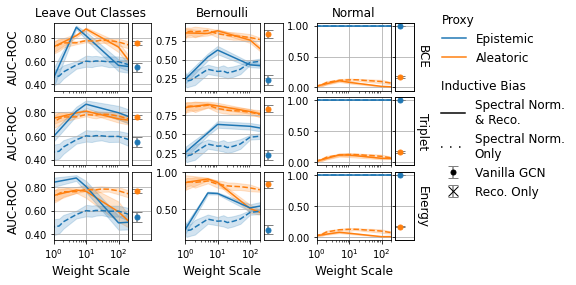

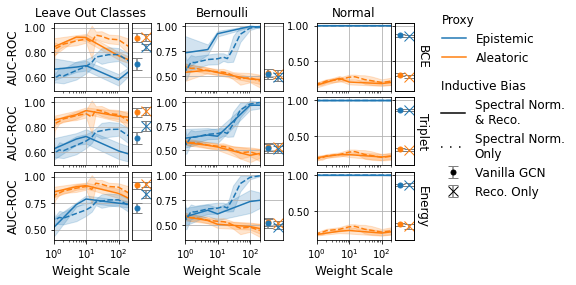

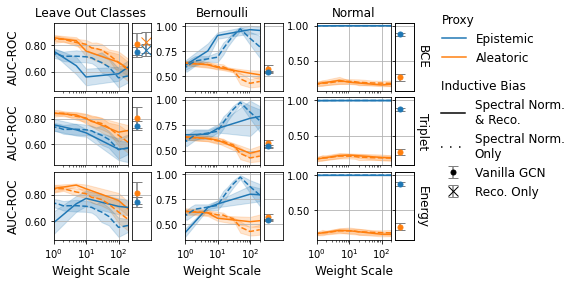

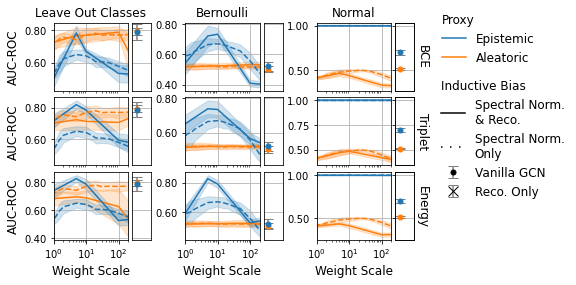

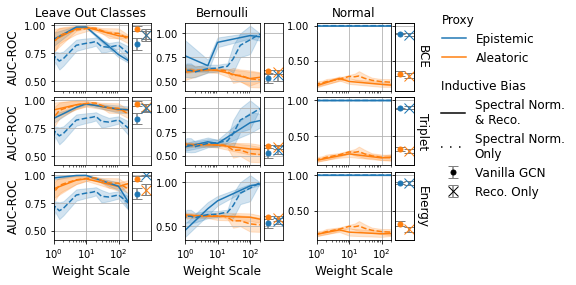

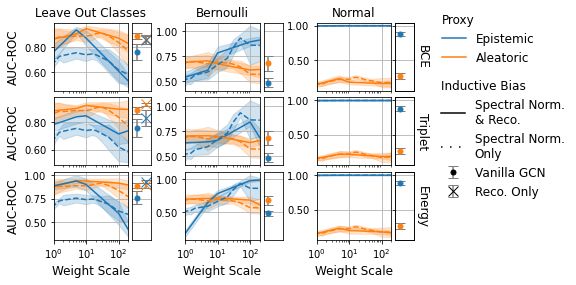

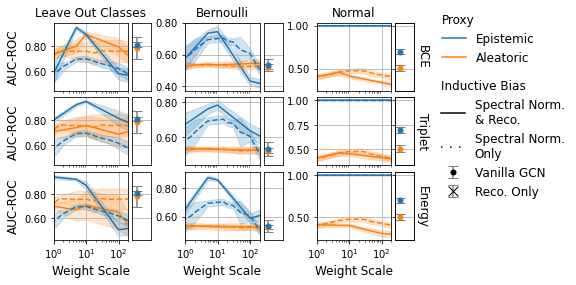

In [32]:
x_name = WEIGHT_SCALE
y_name = METRIC

for no_edges, fn_suffix in ((True, '-no-edges'), (False, '')):
    for setting in (HYBRID, TRANSDUCTIVE):
        for dataset in (dc.CORA_FULL, dc.CITESEER, dc.AMAZON_PHOTO):
            fig, axs = facet_plot_experiment_reco_type_proxy_hue(df_proxy[
                (df_proxy[NO_EDGES] == no_edges) &
                (df_proxy[DATASET] == dataset) &
                (df_proxy[SETTING] == setting)
            ], x_name, y_name)
            
            x_fn = x_name.replace(' ','-').replace('\n', '-')
            y_fn = y_name.replace(' ','-').replace('\n', '-')
            path = f'thesis_nbs/edge_reconstruction_and_spectral_norm_plots/{dataset}-{setting.lower()}-{x_fn}-{y_fn}{fn_suffix}.pdf'
            fig.savefig(path, bbox_inches='tight')
            print(path)
            